### 필수 모듈 임포트

In [2]:
#!pip install gym

     -------------------------------------- 721.7/721.7 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827643 sha256=f4460c3a67cb91a5203f447e99aadb4737693b84ae1d5e63f1ad198d1e6a9cc1
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\af\2b\30\5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [97]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

from IPython import display
%matplotlib inline

### 하이퍼파라미터

In [45]:
# 하이퍼파라미터
EPISODES = 50  # 에피소드 반복 횟수
EPS_START = 0.9  # 학습 시작 시 에이전트가 무작위로 행동할 확률
EPS_END = 0.05  # 학습 막바지에 에이전트가 무작위로 행동할 확률
EPS_DECAY = 200  # 학습 진행 시 에이전트가 무작위로 행동할 확률을 감소시키는 값
GAMMA = 0.8  # 할인계수
LR = 0.001  # 학습률
BATCH_SIZE = 64  # 배치 크기

### DQN 에이전트

In [93]:
# 카트 위치, 카트 속도, 막대기 각도, 막대기 속 --> 왼쪽, 오른쪽
class DQNAgent:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0
        
        # 이전 경험 기억하기
        ## self.memory = [(상태, 행동, 보상, 다음 상태)...]
        self.memory = deque(maxlen=10000)
        
    # 새로운 경험 덧붙이는 함수
    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))
    
    # 행동하기 --> Epsilon-greedy algorithm
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
        
    # 경험으로부터 배우기 --> experience replay
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch)
        
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        
        current_q = self.model(states).gather(1, actions)
        
        # 할인된 미래 가치로 누적된 보상을 극대화하는 방향으로 학습
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### 학습 시작

In [108]:
env = gym.make('CartPole-v0')
agent = DQNAgent()
score_history = []

In [109]:
for e in range(1, EPISODES+1):
    state, _ = env.reset()
    steps = 0
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action.item())

        # 게임이 끝났을 경우 마이너스 보상주기
        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learn()

        state = next_state
        steps += 1

        if done:
            print("에피소드:{0} 점수: {1}".format(e, steps))
            score_history.append(steps)
            break

에피소드:1 점수: 12
에피소드:2 점수: 26
에피소드:3 점수: 10
에피소드:4 점수: 9
에피소드:5 점수: 28
에피소드:6 점수: 29
에피소드:7 점수: 12
에피소드:8 점수: 9
에피소드:9 점수: 18
에피소드:10 점수: 10
에피소드:11 점수: 9
에피소드:12 점수: 14
에피소드:13 점수: 10
에피소드:14 점수: 10
에피소드:15 점수: 11
에피소드:16 점수: 13
에피소드:17 점수: 13
에피소드:18 점수: 9
에피소드:19 점수: 10
에피소드:20 점수: 12
에피소드:21 점수: 11
에피소드:22 점수: 31
에피소드:23 점수: 30
에피소드:24 점수: 51
에피소드:25 점수: 66
에피소드:26 점수: 67
에피소드:27 점수: 88
에피소드:28 점수: 99
에피소드:29 점수: 108
에피소드:30 점수: 75
에피소드:31 점수: 121
에피소드:32 점수: 129
에피소드:33 점수: 132
에피소드:34 점수: 101
에피소드:35 점수: 131
에피소드:36 점수: 175
에피소드:37 점수: 157
에피소드:38 점수: 186
에피소드:39 점수: 121
에피소드:40 점수: 150
에피소드:41 점수: 169
에피소드:42 점수: 110
에피소드:43 점수: 181
에피소드:44 점수: 133
에피소드:45 점수: 144
에피소드:46 점수: 138
에피소드:47 점수: 147
에피소드:48 점수: 164
에피소드:49 점수: 196
에피소드:50 점수: 181


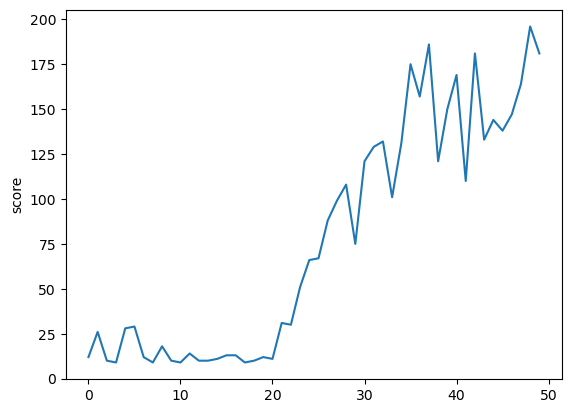

In [110]:
plt.plot(score_history)
plt.ylabel('score')
plt.show()